In [44]:
from nsc.distributions import MultivariateCoupledNormal as MVCN
from nsc.math.entropy_prob import *
from nsc.math.entropy_norm import *
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from nsc.math.function import coupled_logarithm

## I. Creating Random Distribution Parameters for Multivariate Normal Distributions

In [59]:
# Set a random seed for reproducibility.
np.random.seed(1)

# Set the dimensions of each distribution.
d = 2
# Set the number of distributions to compare.
n = 1000

# Generate random numbers for the means of distribution 1.
mu_1 = np.random.normal(loc=0, scale=0.5, size=(n,d))
# Generate random numbers for the means of distribution 2.
mu_2 = np.random.normal(loc=0, scale=0.5, size=(n,d))

# Generate random numbers for the means of distribution 1.
sigma_diag_1 = np.random.normal(loc=1, scale=0.1, size=(n,d))
# Generate random numbers for the means of distribution 2.
sigma_diag_2 = np.random.normal(loc=1, scale=0.1, size=(n,d))

## II. Calculating the KL Divergence using the Analytical Expression

In [66]:
def true_kl_divergence(mu_1, mu_2, sigma_diag_1, sigma_diag_2):
    """This function calculates the true KL divergence between
    two Multivariate Gaussian distributions with diagonal
    covariance matrices.
    
    Inputs
    -------
    mu_1 : numpy.ndarray
        The mean vector of the first distribution.
    mu_2 : numpy.ndarray
        The mean vector of the second distribution.
    sigma_diag_1 : numpy.ndarray
        The diagonal values of the covariance matrix of the first distribution.
    sigma_diag_2 : numpy.ndarray
        The diagonal values of the covariance matrix of the second distribution.
    
    Returns
    -------
    true_kl_div : 
        The analytical KL divergence.
    """
    
    # Calculate the true KL divergence.
    true_kl_div = np.log(np.linalg.det(np.diag(sigma_diag_2))).reshape(-1,) 
    true_kl_div -= np.log(np.linalg.det(np.diag(sigma_diag_1))).reshape(-1,)
    true_kl_div -= mu_1.shape[0]
    true_kl_div += np.trace(np.matmul(np.linalg.inv(np.diag(sigma_diag_2)), np.diag(sigma_diag_1))).reshape(-1,)
    true_kl_div += np.matmul(np.matmul((mu_2 - mu_1), np.linalg.inv(np.diag(sigma_diag_2))), (mu_2 - mu_1).T).reshape(-1,)
    true_kl_div *= 0.5
    
    return true_kl_div

In [60]:
# Create an empty list to hold the KL divergences.
true_kl_divs = []
# Loop through each of the simulated distribution parameters.
for i in range(n):
    # Calculate the KL divergence and append it to the list.
    true_kl_divs.append(true_kl_divergence(mu_1[i], mu_2[i], sigma_diag_1[i], sigma_diag_2[i])[0])

# Convert the list of true KL divergences to a numpy array.
true_kl_divs = np.array(true_kl_divs)

## III. Approximate the KL Divergences using `coupled_kl_divergence_norm()`

In [61]:
# Set the number of approximations to use.
n_approx = 1000

# Instantiate n multivariate normals with the mu_1 means.
mvn_1 = MVCN(loc=mu_1, scale=np.sqrt(sigma_diag_1), kappa=0)
# Instantiate n multivariate normals with the mu_2 means.
mvn_2 = MVCN(loc=mu_2, scale=np.sqrt(sigma_diag_2), kappa=0)

# Get the approximate KL divergences.
approx_kl_divs_1 = coupled_kl_divergence_norm(mvn_1, mvn_2, kappa=0, alpha=2, n=n_approx, seed=1)

## III. Approximate the KL Divergences using a new Approximation Method

In [196]:
def coupled_kl_divergence(p_x, q_x, kappa=0):
    """This function takes in the probability densities of 
    X for distributions p and q. The samples of X should be
    drawn from distribution p. It then returns and estimate of 
    the coupled KL divergence based on a user specified degree of
    coupling.
    
    Inputs
    -------
    p_x : numpy ndarray
        Probability densities of samples of X evaluated with the PDF
        of distribution p (p(x)), where x is a sample of X ~ P(params).
    q_x : numpy ndarray
        Probability densities of samples of X evaluated with the PDF
        of distribution q (q(x)).
    kappa : int or float
        The degree of coupling. Default is 0.
        
    Returns
    -------
    coupled_kl_div : numpy ndarray
        The approximate coupled KL divergence.
    """
    
    # Calculate the approximate KL divergence.
    coupled_kl_div = np.mean(coupled_logarithm(probs_1, kappa=kappa) 
                             - coupled_logarithm(probs_2, kappa=kappa), axis=1)
    
    return coupled_kl_div


In [74]:
# Generate samples from the first distribution.
samples_1 = mvn_1.sample_n(n_approx)

# Get the probability densities for the samples from each distribution.
probs_1 = mvn_1.prob(samples_1).reshape(n, n_approx)
probs_2 = mvn_2.prob(samples_1).reshape(n, n_approx)

# Calculate the approximate KL divergences in a different way.
approx_kl_divs_2 = coupled_kl_divergence(probs_1, probs_2, kappa=0)

## IV. Comparing the Approximations.

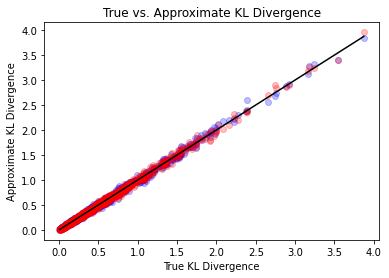

In [90]:
# Get the minimum and maximums to use for a line.
start_kl_div = np.min(true_kl_divs), np.max(true_kl_divs)
end_kl_div = np.min(true_kl_divs), np.max(true_kl_divs)

plt.plot(start_kl_div, end_kl_div,
        color="black")
plt.scatter(true_kl_divs, approx_kl_divs_1,
           color="blue", alpha=0.25)
plt.scatter(true_kl_divs, approx_kl_divs_2,
           color="red", alpha=0.25)
plt.xlabel("True KL Divergence")
plt.ylabel("Approximate KL Divergence")
plt.title("True vs. Approximate KL Divergence")
plt.show()

In [91]:
# Calculate the MSE of the approximate KL divergences
mse_approx_1 = np.mean((true_kl_divs - approx_kl_divs_1)**2)
mse_approx_2 = np.mean((true_kl_divs - approx_kl_divs_2)**2)

print(f"MSE of Approximation 1: {np.round(mse_approx_1, 5)}")
print(f"MSE of Approximation 2: {np.round(mse_approx_2, 5)}")

MSE of Approximation 1: 0.00109
MSE of Approximation 2: 0.00098


## V. Trying Different Coupling Values

In [197]:
# Set the dimensions of each distribution.
d = 2
# Set the number of distributions to compare.
n = 30
# Set the number of approximations to use.
n_approx = 1000

# Generate random numbers for the means of distribution 1.
mu_1 = np.random.normal(loc=0, scale=0.1, size=(n,d))
# Generate random numbers for the means of distribution 2.
mu_2 = np.random.normal(loc=0, scale=0.1, size=(n,d))

# Generate random numbers for the means of distribution 1.
sigma_diag_1 = np.random.normal(loc=1, scale=0.1, size=(n,d))
# Generate random numbers for the means of distribution 2.
sigma_diag_2 = np.random.normal(loc=1, scale=0.1, size=(n,d))

In [198]:
# Set a range of kappa values to try.
kappas = np.arange(0, 1+0.1, 0.1)

# Create empty lists to hold the approximate coupled KL-divergences at different kappas.
approx_kl_divs_1_alt_0 = []
approx_kl_divs_2_alt_0 = []
approx_kl_divs_1_alt_001 = []
approx_kl_divs_2_alt_001 = []
approx_kl_divs_1_alt_01 = []
approx_kl_divs_2_alt_01 = []


# Loop through the values of kappa.
for kappa in kappas:
    
    # Instantiate n multivariate normals with the mu_1 means.
    mvn_1 = MVCN(loc=mu_1, scale=np.sqrt(sigma_diag_1), kappa=kappa)
    # Instantiate n multivariate normals with the mu_2 means.
    mvn_2 = MVCN(loc=mu_2, scale=np.sqrt(sigma_diag_2), kappa=kappa)
    
    # Get the approximate KL divergences.
    approx_kl_divs_1_alt_0.append(coupled_kl_divergence_norm(mvn_1, mvn_2, kappa=0, alpha=2, n=n_approx, seed=1))
    # Get the approximate KL divergences.
    approx_kl_divs_1_alt_001.append(coupled_kl_divergence_norm(mvn_1, mvn_2, kappa=0.01, alpha=2, n=n_approx, seed=1))
    # Get the approximate KL divergences.
    approx_kl_divs_1_alt_01.append(coupled_kl_divergence_norm(mvn_1, mvn_2, kappa=0.1, alpha=2, n=n_approx, seed=1))
    
    ###
    # Calculate the approximate KL divergences in a different way.
    ###
    
    # Generate samples from the first distribution.
    samples_1 = mvn_1.sample_n(n_approx)
    
    # Get the probability densities for the samples from each distribution.
    probs_1 = mvn_1.prob(samples_1).reshape(n, n_approx)
    probs_2 = mvn_2.prob(samples_1).reshape(n, n_approx)
    approx_kl_divs_2_alt_0.append(coupled_kl_divergence(probs_1, probs_2, kappa=0))
    approx_kl_divs_2_alt_001.append(coupled_kl_divergence(probs_1, probs_2, kappa=0.01))
    approx_kl_divs_2_alt_01.append(coupled_kl_divergence(probs_1, probs_2, kappa=0.1))

In [199]:
# Convert them to numpy arrays.
approx_kl_divs_1_alt_0, approx_kl_divs_2_alt_0 = np.array(approx_kl_divs_1_alt_0), np.array(approx_kl_divs_2_alt_0)
approx_kl_divs_1_alt_001, approx_kl_divs_2_alt_001 = np.array(approx_kl_divs_1_alt_001), np.array(approx_kl_divs_2_alt_001)
approx_kl_divs_1_alt_01, approx_kl_divs_2_alt_01 = np.array(approx_kl_divs_1_alt_01), np.array(approx_kl_divs_2_alt_01)
# Create arrays of kappa for plotting.
kappas_plotting = np.repeat(kappas, n).reshape(len(kappas), n)

C:\Users\jkcle\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


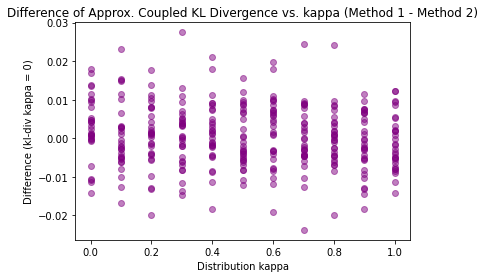

In [200]:
plt.scatter(kappas_plotting, approx_kl_divs_1_alt_0 - approx_kl_divs_2_alt_0,
           color="purple", alpha=0.5)
plt.xlabel("Distribution kappa")
plt.ylabel("Difference (kl-div kappa = 0)")
plt.title("Difference of Approx. Coupled KL Divergence vs. kappa (Method 1 - Method 2)")
plt.show()

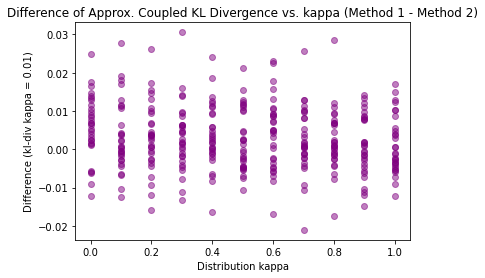

In [201]:
plt.scatter(kappas_plotting, approx_kl_divs_1_alt_001 - approx_kl_divs_2_alt_001,
           color="purple", alpha=0.5)
plt.xlabel("Distribution kappa")
plt.ylabel("Difference (kl-div kappa = 0.01)")
plt.title("Difference of Approx. Coupled KL Divergence vs. kappa (Method 1 - Method 2)")
plt.show()

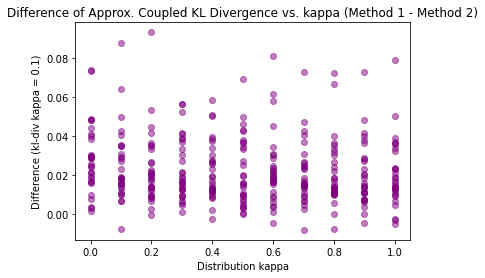

In [202]:
plt.scatter(kappas_plotting, approx_kl_divs_1_alt_01 - approx_kl_divs_2_alt_01,
           color="purple", alpha=0.5)
plt.xlabel("Distribution kappa")
plt.ylabel("Difference (kl-div kappa = 0.1)")
plt.title("Difference of Approx. Coupled KL Divergence vs. kappa (Method 1 - Method 2)")
plt.show()